In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

import torch
from torch import nn

# Intersection over Union (IoU)

In [2]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Tính toán độ chồng lấn giữa các box giới hạn
    Parameters:
        boxes_preds (tensor): Dự đoán về các box giới hạn (BATCH_SIZE, 4)
        boxes_labels (tensor): Nhãn chính xác của các box giới hạn (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, nếu box giới hạn được biểu diễn dưới dạng (x,y,w,h) hoặc (x1,y1,x2,y2)
    Returns:
        tensor: Độ chồng lấn giữa các ví dụ
    """

    # Kiểm tra nếu định dạng box là "midpoint"
    if box_format == "midpoint":
        # Tính toán tọa độ của điểm trên bên trái (x1, y1) và điểm dưới bên phải (x2, y2) cho các box dự đoán
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        # Tính toán tọa độ của điểm trên bên trái (x1, y1) và điểm dưới bên phải (x2, y2) cho nhãn thực
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    # Kiểm tra nếu định dạng box là "corners"
    if box_format == "corners":
        # Trích xuất tọa độ cho các box dự đoán
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)

        # Trích xuất tọa độ cho nhãn thực
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # Tính toán tọa độ của hình chữ nhật giao nhau
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) dùng để xử lý trường hợp chúng không giao nhau
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Tính toán diện tích của hình chữ nhật giao nhau
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # Trả về tỷ lệ độ chồng lấn giữa các box giới hạn, thêm một epsilon nhỏ để tránh chia cho 0
    return intersection / (box1_area + box2_area - intersection + 1e-6)

Intersection over Union: tensor([0.4645])


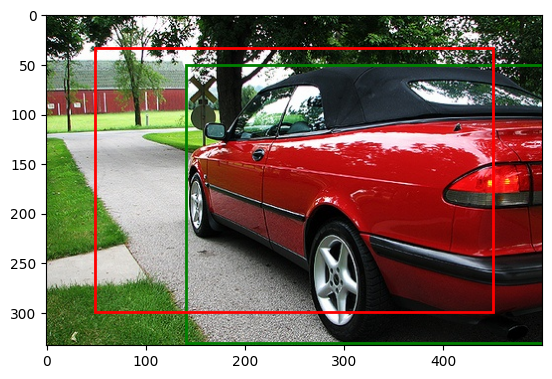

In [3]:
# Load image
image = Image.open("images/000007.jpg")

# Load label
with open("labels/000007.txt") as f:
    boxes_gt = f.readlines()
    
# Convert sang định dạng (x, y, width, height)
boxes_gt = [box.strip().split(" ") for box in boxes_gt]
boxes_gt = [[float(x) for x in box] for box in boxes_gt][0]

boxes_corners_gt = boxes_gt.copy()

boxes_corners_gt[1] = int((boxes_gt[1] - boxes_gt[3] / 2) * image.width)
boxes_corners_gt[2] = int((boxes_gt[2] - boxes_gt[4] / 2) * image.height)
boxes_corners_gt[3] = int((boxes_gt[1] + boxes_gt[3] / 2) * image.width)
boxes_corners_gt[4] = int((boxes_gt[2] + boxes_gt[4] / 2) * image.height)

# Plot label vào image
plt.imshow(image)
# plt.axis("off")
plt.gca().add_patch(plt.Rectangle((boxes_corners_gt[1], boxes_corners_gt[2]), boxes_corners_gt[3] - boxes_corners_gt[1], boxes_corners_gt[4] - boxes_corners_gt[2], 
                                  fill=False, edgecolor='g', linewidth=2))

# Tạo ví dụ bounding boxes
boxes_preds = [1.0, 0.5, 0.5, 0.8, 0.8]

boxes_corners_preds = boxes_preds.copy()

# Vẽ bounding boxes preds lên image
boxes_corners_preds[1] = int((boxes_preds[1] - boxes_preds[3] / 2) * image.width)
boxes_corners_preds[2] = int((boxes_preds[2] - boxes_preds[4] / 2) * image.height)
boxes_corners_preds[3] = int((boxes_preds[1] + boxes_preds[3] / 2) * image.width)
boxes_corners_preds[4] = int((boxes_preds[2] + boxes_preds[4] / 2) * image.height)
plt.gca().add_patch(plt.Rectangle((boxes_corners_preds[1], boxes_corners_preds[2]), boxes_corners_preds[3] - boxes_corners_preds[1], boxes_corners_preds[4] - boxes_corners_preds[2],
                                    fill=False, edgecolor='r', linewidth=2))

# IoU
boxes_corners_gt = torch.tensor(boxes_corners_gt)
boxes_corners_preds = torch.tensor(boxes_corners_preds)

iou = intersection_over_union(boxes_corners_preds, boxes_corners_gt)
print("Intersection over Union:", iou)

Intersection over Union: tensor([0.6195])


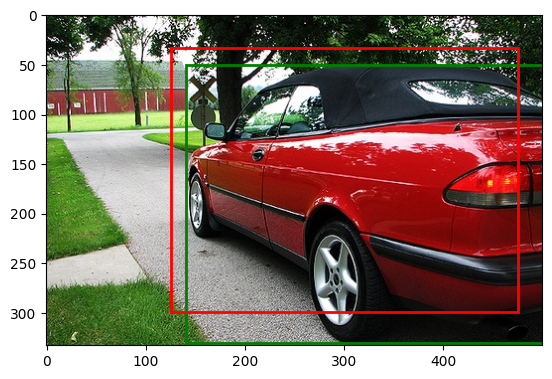

In [4]:
# Load image
image = Image.open("images/000007.jpg")

# Load label
with open("labels/000007.txt") as f:
    boxes_gt = f.readlines()
    
# Convert sang định dạng (x, y, width, height)
boxes_gt = [box.strip().split(" ") for box in boxes_gt]
boxes_gt = [[float(x) for x in box] for box in boxes_gt][0]

boxes_corners_gt = boxes_gt.copy()

boxes_corners_gt[1] = int((boxes_gt[1] - boxes_gt[3] / 2) * image.width)
boxes_corners_gt[2] = int((boxes_gt[2] - boxes_gt[4] / 2) * image.height)
boxes_corners_gt[3] = int((boxes_gt[1] + boxes_gt[3] / 2) * image.width)
boxes_corners_gt[4] = int((boxes_gt[2] + boxes_gt[4] / 2) * image.height)

# Plot label vào image
plt.imshow(image)
# plt.axis("off")
plt.gca().add_patch(plt.Rectangle((boxes_corners_gt[1], boxes_corners_gt[2]), boxes_corners_gt[3] - boxes_corners_gt[1], boxes_corners_gt[4] - boxes_corners_gt[2], 
                                  fill=False, edgecolor='g', linewidth=2))

# Tạo ví dụ bounding boxes
boxes_preds = [1.0, 0.6, 0.5, 0.7, 0.8]

boxes_corners_preds = boxes_preds.copy()

# Vẽ bounding boxes preds lên image
boxes_corners_preds[1] = int((boxes_preds[1] - boxes_preds[3] / 2) * image.width)
boxes_corners_preds[2] = int((boxes_preds[2] - boxes_preds[4] / 2) * image.height)
boxes_corners_preds[3] = int((boxes_preds[1] + boxes_preds[3] / 2) * image.width)
boxes_corners_preds[4] = int((boxes_preds[2] + boxes_preds[4] / 2) * image.height)
plt.gca().add_patch(plt.Rectangle((boxes_corners_preds[1], boxes_corners_preds[2]), boxes_corners_preds[3] - boxes_corners_preds[1], boxes_corners_preds[4] - boxes_corners_preds[2],
                                    fill=False, edgecolor='r', linewidth=2))

# IoU
boxes_corners_gt = torch.tensor(boxes_corners_gt)
boxes_corners_preds = torch.tensor(boxes_corners_preds)

iou = intersection_over_union(boxes_corners_preds, boxes_corners_gt)
print("Intersection over Union:", iou)

# Non Max Suppression

In [5]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Thực hiện Non-Maximum Suppression trên danh sách các box giới hạn
    Parameters:
        bboxes (list): Danh sách các box giới hạn, mỗi box được biểu diễn như [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): Ngưỡng IoU để xác định box giới hạn dự đoán là đúng
        threshold (float): Ngưỡng để loại bỏ các box giới hạn dự đoán (không phụ thuộc vào IoU)
        box_format (str): "midpoint" hoặc "corners" để chỉ định định dạng của box giới hạn
    Returns:
        list: Danh sách các box giới hạn sau khi thực hiện NMS với một ngưỡng IoU cụ thể
    """

    # Kiểm tra kiểu dữ liệu của tham số đầu vào
    assert type(bboxes) == list

    # Lọc các box giới hạn dự đoán dựa trên ngưỡng xác suất
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sắp xếp các box giới hạn theo xác suất giảm dần
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # Danh sách để lưu trữ các box giới hạn sau khi thực hiện NMS
    bboxes_after_nms = []

    # Thực hiện vòng lặp cho đến khi danh sách box giới hạn rỗng
    while bboxes:
        # Lấy box giới hạn có xác suất cao nhất
        chosen_box = bboxes.pop(0)

        # Loại bỏ các box giới hạn có IoU lớn hơn ngưỡng được chỉ định với box giới hạn đã chọn
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        # Thêm box giới hạn đã chọn vào danh sách sau khi thực hiện NMS
        bboxes_after_nms.append(chosen_box)

    # Trả về danh sách các box giới hạn sau khi thực hiện NMS
    return bboxes_after_nms

Sau khi áp dụng non-max suppression: [[2, 0.9, 0.4, 0.2, 0.8, 0.8]]


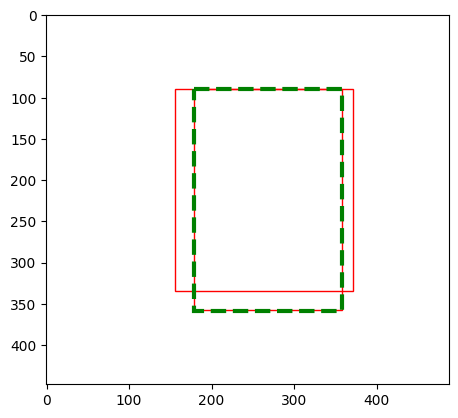

In [6]:
# Tạo các mẫu bounding boxes và score
# [class_pred, prob_score, x1, y1, x2, y2]
bboxes = ([[2, 0.9, 0.4, 0.2, 0.8, 0.8],    # Box 1
           [2, 0.8, 0.35, 0.2, 0.83, 0.75],    # Box 2 (chồng chéo với Box 1)
           ])  


# Định nghĩa ngưỡng cho IoU
# Ngưỡng này quyết định mức độ chồng chéo tối đa được phép giữa các box
iou_threshold = 0.5

# Định nghĩa ngưỡng cho điểm số
# Chỉ những box có điểm số cao hơn ngưỡng này mới được xem xét
score_threshold = 0.4

# Kiểm tra hàm non_max_suppression
# Hàm này sẽ lọc ra các box dựa trên ngưỡng IoU và điểm số
nms_bboxes = non_max_suppression(bboxes, iou_threshold, score_threshold, box_format="midpoint")
print("Sau khi áp dụng non-max suppression:", nms_bboxes)


# Create a blank 448
image = np.ones((448, 488, 3))

# Plot the image
plt.imshow(image)

# Vẽ bounding boxes gốc
for bbox in bboxes:
    class_pred, prob_score, x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    
    # rescale lại tọa độ của bounding box
    x1 = int(x1 * 448)
    y1 = int(y1 * 448)
    width = int(width * 448)
    height = int(height * 448)

    plt.gca().add_patch(plt.Rectangle((x1, y1), width, height, fill=False, edgecolor='r'))
    

# Vẽ nms_bboxes bounding boxes trên image mới
plt.gca().add_patch(plt.Rectangle((nms_bboxes[0][2]*448, nms_bboxes[0][3]*448), nms_bboxes[0][4]*448 - nms_bboxes[0][2]*448, nms_bboxes[0][5]*448 - nms_bboxes[0][3]*448, 
                                  fill=False, edgecolor='g', linewidth=3, linestyle='--'))

# Show the plot
plt.show()

# Mean Average Precision (mAP)

In [7]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Tính giá trị trung bình độ chính xác (mAP)
    Parameters:
        pred_boxes (list): danh sách chứa các box giới hạn dự đoán với mỗi box được chỉ định như [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Tương tự như pred_boxes nhưng chứa thông tin về các box đúng
        iou_threshold (float): ngưỡng IoU, nơi các box dự đoán được coi là đúng
        box_format (str): "midpoint" hoặc "corners" được sử dụng để chỉ định định dạng của các box
        num_classes (int): số lượng lớp
    Returns:
        float: Giá trị mAP qua tất cả các lớp với một ngưỡng IoU cụ thể
    """

    # Danh sách lưu trữ mAP cho từng lớp
    average_precisions = []

    # Sử dụng để ổn định số học sau này
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Xem qua tất cả các dự đoán và mục tiêu,
        # và chỉ thêm những cái thuộc về
        # lớp c hiện tại
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # Tìm số lượng box cho mỗi ví dụ huấn luyện
        # Counter ở đây tìm số lượng box đích mà chúng ta có
        # cho mỗi ví dụ huấn luyện, vì vậy giả sử ảnh 0 có 3,
        # ảnh 1 có 5 thì chúng ta sẽ có một từ điển với:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # Chúng ta sau đó duyệt qua mỗi key, val trong từ điển này
        # và chuyển đổi sang dạng sau (đối với cùng một ví dụ):
        # amount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sắp xếp theo xác suất box, index 2 là xác suất
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # Nếu không có box nào tồn tại cho lớp này thì có thể bỏ qua an toàn
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Chỉ lấy ra các box đích có cùng
            # chỉ số huấn luyện như dự đoán
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                #Chỉ detect ground truth một lần
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive và thêm box giới hạn này vào để xem
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # nếu IOU thấp hơn thì kết quả phát hiện là false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz để tích hợp số
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [8]:
# Format cho mỗi box: [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
ground_truths = [[1, 12, 1, 25/255., 25/255., 50/255., 50/255.]]

predictions   = [[1, 12, 0.9, 22/255., 22/255., 64/255., 50/255.]]

# Test the mean_average_precision function
map_value = mean_average_precision(predictions, ground_truths, iou_threshold=0.5)
print(f"mAP = {map_value}")

mAP = 0.9999985694885254


# YOLOv1

In [9]:
"""
Thông tin về cấu hình kiến trúc:
Tuple được cấu trúc bởi (kernel_size, bộ lọc, bước tiến, phần đệm)
"M" chỉ đơn giản là maxpooling với sải chân 2x2 và kernel 2x2
Danh sách được cấu trúc theo bộ dữ liệu và cuối cùng là int với số lần lặp lại
"""
# Mô tả các lớp convolution và max pooling, số lần lặp lại các khối convolution.
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

# Một khối convolution được định nghĩa với các lớp Conv2d, BatchNorm2d, và LeakyReLU.
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

# Mô hình YOLOv1 được định nghĩa với các lớp convolution và các lớp fully connected layer (fcs).
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        print(f"Output shape of darknet: {x.shape}")
        out = self.fcs(torch.flatten(x, start_dim=1))
        print(f"Output shape of fcs: {out.shape}")
        return out

# Hàm tạo ra các lớp convolution dựa trên cấu trúc kiến trúc đã được định nghĩa trước đó.
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

# Hàm tạo ra các lớp fully connected layer dựa trên các thông số đầu vào như kích thước ô chia, số lượng hộp, và số lớp.
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [10]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)

In [11]:
x = torch.randn((32, 3, 448, 448))

y = model(x)

Output shape of darknet: torch.Size([32, 1024, 7, 7])
Output shape of fcs: torch.Size([32, 1470])


# YOLO loss

In [12]:
# Một lớp từ nn.Module để tính toán hàm mất mát cho mô hình YOLOv1.
class YoloLoss(nn.Module):
    """
    Tính loss cho mô hình yolo (v1)
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S là kích thước chia nhỏ của ảnh (7),
        B là số hộp (2),
        C là số lớp (tập dữ liệu VOC là 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # Đây là từ Yolo, biểu thị mức độ nên làm
        # trả lỗ cho không có đối tượng (noobj) và hộp tọa độ (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # Dự đoán được định hình (BATCH_SIZE, S*S(C+B*5) khi được nhập vào
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Tính IoU cho hai hộp giới hạn được dự đoán với hộp mục tiêu
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Lấy hộp có IoU cao nhất trong 2 dự đoán
        # Lưu ý bestbox sẽ có chỉ số 0, 1 bbox nào tốt nhất
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Đặt các box không có đối tượng trong đó thành 0. Lấy ra một trong hai
        # dự đoán, là dự đoán có Iou cao nhất được tính toán trước đó.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Lấy sqrt của chiều rộng, chiều cao của box để đảm bảo
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box là điểm tin cậy của bbox có IoU cao nhất
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(dự đoán[..., 20:21], dự đoán[..., 25:26])
        #no_object_loss = self.mse(
        # torch.flatten((1 - tồn tại_box) * max_no_obj, start_dim=1),
        # torch.flatten((1 - tồn tại_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # 2 hàng đầu
            + object_loss  # hàng thứ 3 in paper
            + self.lambda_noobj * no_object_loss  # hàng thứ 4
            + class_loss  # hàng thứ 5
        )

        return loss

In [13]:
loss_fn = YoloLoss()

# S=7, B=2, C=20
output = torch.randn((32, 1470))
y = torch.randn((32, 7, 7, 30))

# Tính loss
loss = loss_fn(output, y)

# In loss
print(loss)

tensor(nan)
